In [2]:
!pip install prefetch-generator==1.0.1
!pip install gdown
!pip install lapx==0.5.10
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.8/871.8 kB 13.5 MB/s eta 0:00:00a 0:00:01


In [3]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.91 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5845.9/8062.4 GB disk)


In [4]:
import os
import datetime

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import torch
import numpy as np
import os.path as osp

import yaml
from collections import OrderedDict
from shutil import copyfile, copytree
import pickle
import warnings
try:
    import neptune
except Exception:
    print('Neptune is not installed.')



Neptune is not installed.


In [5]:
def load_checkpoint(fpath):
    # """Loads checkpoint.
    # ``UnicodeDecodeError`` can be well handled, which means
    # python2-saved files can be read from python3.
    # Args:
    #     fpath (str): path to checkpoint.
    # Returns:
    #     dict
    # Examples::
    #     >>> from torchreid.utils import load_checkpoint
    #     >>> fpath = 'log/my_model/model.pth.tar-10'
    #     >>> checkpoint = load_checkpoint(fpath)
    # """
    if fpath is None:
        raise ValueError('File path is None')
    if not osp.exists(fpath):
        raise FileNotFoundError('File is not found at "{}"'.format(fpath))
    map_location = None if torch.cuda.is_available() else 'cpu'
    try:
        checkpoint = torch.load(fpath, map_location=map_location)
    except UnicodeDecodeError:
        pickle.load = partial(pickle.load, encoding="latin1")
        pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
        checkpoint = torch.load(
            fpath, pickle_module=pickle, map_location=map_location
        )
    except Exception:
        print('Unable to load checkpoint from "{}"'.format(fpath))
        raise
    return checkpoint

def load_pretrained_weights(model, weight_path):
    r"""Loads pretrianed weights to model.
    Features::
        - Incompatible layers (unmatched in name or size) will be ignored.
        - Can automatically deal with keys containing "module.".
    Args:
        model (nn.Module): network model.
        weight_path (str): path to pretrained weights.
    Examples::
        >>> from torchreid.utils import load_pretrained_weights
        >>> weight_path = 'log/my_model/model-best.pth.tar'
        >>> load_pretrained_weights(model, weight_path)
    """
    checkpoint = load_checkpoint(weight_path)
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    model_dict = model.state_dict()
    new_state_dict = OrderedDict()
    matched_layers, discarded_layers = [], []
    for k, v in state_dict.items():

        if k.startswith('module.'):
            k = 'model.' + k[7:]  # discard module.
        if k.startswith('model.'):
            k = k[6:]
        if k in model_dict and model_dict[k].size() == v.size():

            new_state_dict[k] = v
            matched_layers.append(k)
        else:
            discarded_layers.append(k)

    model_dict.update(new_state_dict)
    model.load_state_dict(model_dict)

    if len(matched_layers) == 0:
        warnings.warn(
            'The pretrained weights "{}" cannot be loaded, '
            'please check the key names manually '
            '(** ignored and continue **)'.format(weight_path)
        )
    else:
        print('[INFO] Successfully loaded pretrained weights from "{}"'.
                       format(weight_path))
        if len(discarded_layers) > 0:
            print(
                '** The following layers are discarded '
                'due to unmatched keys or layer size: {}'.
                format(discarded_layers)
            )


In [6]:
from __future__ import absolute_import
from __future__ import division

__all__ = ['osnet_x1_25', 'osnet_x1_0', 'osnet_x0_75', 'osnet_x0_5', 'osnet_x0_25', 'osnet_ibn_x1_0']

import torch
from torch import nn
from torch.nn import functional as F
import torchvision


pretrained_urls = {
    'osnet_x1_0': 'https://drive.google.com/uc?id=1LaG1EJpHrxdAxKnSCJ_i0u-nbxSAeiFY',
    'osnet_x0_75': 'https://drive.google.com/uc?id=1uwA9fElHOk3ZogwbeY5GkLI6QPTX70Hq',
    'osnet_x0_5': 'https://drive.google.com/uc?id=16DGLbZukvVYgINws8u8deSaOqjybZ83i',
    'osnet_x0_25': 'https://drive.google.com/uc?id=1rb8UN5ZzPKRc_xvtHlyDh-cSz88YX9hs',
    'osnet_ibn_x1_0': 'https://drive.google.com/uc?id=1sr90V6irlYYDd4_4ISU2iruoRG8J__6l'
}


##########
# Basic layers
##########
class ConvLayer(nn.Module):
    """Convolution layer (conv + bn + relu)."""
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, IN=False):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride,
                              padding=padding, bias=False, groups=groups)
        if IN:
            self.bn = nn.InstanceNorm2d(out_channels, affine=True)
        else:
            self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Conv1x1(nn.Module):
    """1x1 convolution + bn + relu."""
    
    def __init__(self, in_channels, out_channels, stride=1, groups=1):
        super(Conv1x1, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1, stride=stride, padding=0,
                              bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Conv1x1Linear(nn.Module):
    """1x1 convolution + bn (w/o non-linearity)."""
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(Conv1x1Linear, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1, stride=stride, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class Conv3x3(nn.Module):
    """3x3 convolution + bn + relu."""
    
    def __init__(self, in_channels, out_channels, stride=1, groups=1):
        super(Conv3x3, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1,
                              bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class LightConv3x3(nn.Module):
    """Lightweight 3x3 convolution.
    1x1 (linear) + dw 3x3 (nonlinear).
    """
    
    def __init__(self, in_channels, out_channels):
        super(LightConv3x3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False, groups=out_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


##########
# Building blocks for omni-scale feature learning
##########
class ChannelGate(nn.Module):
    """A mini-network that generates channel-wise gates conditioned on input tensor."""

    def __init__(self, in_channels, num_gates=None, return_gates=False,
                 gate_activation='sigmoid', reduction=16, layer_norm=False):
        super(ChannelGate, self).__init__()
        if num_gates is None:
            num_gates = in_channels
        self.return_gates = return_gates
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels//reduction, kernel_size=1, bias=True, padding=0)
        self.norm1 = None
        if layer_norm:
            self.norm1 = nn.LayerNorm((in_channels//reduction, 1, 1))
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels//reduction, num_gates, kernel_size=1, bias=True, padding=0)
        if gate_activation == 'sigmoid':
            self.gate_activation = nn.Sigmoid()
        elif gate_activation == 'relu':
            self.gate_activation = nn.ReLU(inplace=True)
        elif gate_activation == 'linear':
            self.gate_activation = None
        else:
            raise RuntimeError("Unknown gate activation: {}".format(gate_activation))

    def forward(self, x):
        input = x
        x = self.global_avgpool(x)
        x = self.fc1(x)
        if self.norm1 is not None:
            x = self.norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        if self.gate_activation is not None:
            x = self.gate_activation(x)
        if self.return_gates:
            return x
        return input * x


class OSBlock(nn.Module):
    """Omni-scale feature learning block."""
    
    def __init__(self, in_channels, out_channels, IN=False, bottleneck_reduction=4, **kwargs):
        super(OSBlock, self).__init__()
        mid_channels = out_channels // bottleneck_reduction
        self.conv1 = Conv1x1(in_channels, mid_channels)
        self.conv2a = LightConv3x3(mid_channels, mid_channels)
        self.conv2b = nn.Sequential(
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
        )
        self.conv2c = nn.Sequential(
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
        )
        self.conv2d = nn.Sequential(
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
        )
        self.gate = ChannelGate(mid_channels)
        self.conv3 = Conv1x1Linear(mid_channels, out_channels)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = Conv1x1Linear(in_channels, out_channels)
        self.IN = None
        if IN:
            self.IN = nn.InstanceNorm2d(out_channels, affine=True)

    def forward(self, x):
        identity = x
        x1 = self.conv1(x)
        x2a = self.conv2a(x1)
        x2b = self.conv2b(x1)
        x2c = self.conv2c(x1)
        x2d = self.conv2d(x1)
        x2 = self.gate(x2a) + self.gate(x2b) + self.gate(x2c) + self.gate(x2d)
        x3 = self.conv3(x2)
        if self.downsample is not None:
            identity = self.downsample(identity)
        out = x3 + identity
        if self.IN is not None:
            out = self.IN(out)
        return F.relu(out)


##########
# Network architecture
##########
class OSNet(nn.Module):
    """Omni-Scale Network.
    
    Reference:
        - Zhou et al. Omni-Scale Feature Learning for Person Re-Identification. ICCV, 2019.
    """

    def __init__(self, num_classes, blocks, layers, channels, feature_dim=512, loss='softmax', IN=False, **kwargs):
        super(OSNet, self).__init__()
        num_blocks = len(blocks)
        assert num_blocks == len(layers)
        assert num_blocks == len(channels) - 1 
        self.loss = loss
        
        # convolutional backbone
        self.conv1 = ConvLayer(3, channels[0], 7, stride=2, padding=3, IN=IN)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2 = self._make_layer(blocks[0], layers[0], channels[0], channels[1], reduce_spatial_size=True, IN=IN)
        self.conv3 = self._make_layer(blocks[1], layers[1], channels[1], channels[2], reduce_spatial_size=True)
        self.conv4 = self._make_layer(blocks[2], layers[2], channels[2], channels[3], reduce_spatial_size=False)
        self.conv5 = Conv1x1(channels[3], channels[3])
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        # fully connected layer
        self.fc = self._construct_fc_layer(feature_dim, channels[3], dropout_p=None)
        # identity classification layer
        self.classifier = nn.Linear(self.feature_dim, num_classes)
        
        self._init_params()

    def _make_layer(self, block, layer, in_channels, out_channels, reduce_spatial_size, IN=False):
        layers = []
        
        layers.append(block(in_channels, out_channels, IN=IN))
        for i in range(1, layer):
            layers.append(block(out_channels, out_channels, IN=IN))
        
        if reduce_spatial_size:
            layers.append(
                nn.Sequential(
                    Conv1x1(out_channels, out_channels),
                    nn.AvgPool2d(2, stride=2)
                )
            )
        
        return nn.Sequential(*layers)

    def _construct_fc_layer(self, fc_dims, input_dim, dropout_p=None):
        if fc_dims is None or fc_dims<0:
            self.feature_dim = input_dim
            return None
        
        if isinstance(fc_dims, int):
            fc_dims = [fc_dims]
        
        layers = []
        for dim in fc_dims:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.ReLU(inplace=True))
            if dropout_p is not None:
                layers.append(nn.Dropout(p=dropout_p))
            input_dim = dim
        
        self.feature_dim = fc_dims[-1]
        
        return nn.Sequential(*layers)

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def featuremaps(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

    def forward(self, x, return_featuremaps=False):
        x = self.featuremaps(x)
        if return_featuremaps:
            return x
        v = self.global_avgpool(x)
        v = v.view(v.size(0), -1)
        if self.fc is not None:
            v = self.fc(v)
        if not self.training:
            return v
        y = self.classifier(v)
        if self.loss == 'softmax':
            return y
        elif self.loss == 'triplet':
            return y, v
        else:
            raise KeyError("Unsupported loss: {}".format(self.loss))


def init_pretrained_weights(model, key=''):
    """Initializes model with pretrained weights.
    
    Layers that don't match with pretrained layers in name or size are kept unchanged.
    """
    import os
    import errno
    import gdown
    from collections import OrderedDict

    def _get_torch_home():
        ENV_TORCH_HOME = 'TORCH_HOME'
        ENV_XDG_CACHE_HOME = 'XDG_CACHE_HOME'
        DEFAULT_CACHE_DIR = '~/.cache'
        torch_home = os.path.expanduser(
            os.getenv(ENV_TORCH_HOME,
                      os.path.join(os.getenv(ENV_XDG_CACHE_HOME, DEFAULT_CACHE_DIR), 'torch')))
        return torch_home
    
    torch_home = _get_torch_home()
    model_dir = os.path.join(torch_home, 'checkpoints')
    try:
        os.makedirs(model_dir)
    except OSError as e:
        if e.errno == errno.EEXIST:
            # Directory already exists, ignore.
            pass
        else:
            # Unexpected OSError, re-raise.
            raise
    filename = key + '_imagenet.pth'
    cached_file = os.path.join(model_dir, filename)

    if not os.path.exists(cached_file):
        gdown.download(pretrained_urls[key], cached_file, quiet=True)

    state_dict = torch.load(cached_file)
    model_dict = model.state_dict()
    new_state_dict = OrderedDict()
    matched_layers, discarded_layers = [], []
    
    for k, v in state_dict.items():
        if k.startswith('module.'):
            k = k[7:] # discard module.
        
        if k in model_dict and model_dict[k].size() == v.size():
            new_state_dict[k] = v
            matched_layers.append(k)
        else:
            discarded_layers.append(k)
    
    model_dict.update(new_state_dict)
    model.load_state_dict(model_dict)
    
    if len(matched_layers) == 0:
        warnings.warn(
            'The pretrained weights from "{}" cannot be loaded, '
            'please check the key names manually '
            '(** ignored and continue **)'.format(cached_file))
    else:
        print('Successfully loaded imagenet pretrained weights from "{}"'.format(cached_file))
        if len(discarded_layers) > 0:
            print('** The following layers are discarded '
                  'due to unmatched keys or layer size: {}'.format(discarded_layers))


##########
# Instantiation
##########
def osnet_x1_25(num_classes=1000, pretrained=True, loss='softmax', **kwargs):
    # standard size (width x1.25)
    return OSNet(num_classes, blocks=[OSBlock, OSBlock, OSBlock], layers=[2, 2, 2],
                 channels=[80, 320, 480, 640], loss=loss, **kwargs)
    if pretrained:
        init_pretrained_weights(model, key='osnet_x1_25')

def osnet_x1_0(num_classes=1000, pretrained=True, loss='softmax', **kwargs):
    # standard size (width x1.0)
    model = OSNet(num_classes, blocks=[OSBlock, OSBlock, OSBlock], layers=[2, 2, 2],
                  channels=[64, 256, 384, 512], loss=loss, **kwargs)
    if pretrained:
        init_pretrained_weights(model, key='osnet_x1_0')
    return model


def osnet_x0_75(num_classes=1000, pretrained=True, loss='softmax', **kwargs):
    # medium size (width x0.75)
    model = OSNet(num_classes, blocks=[OSBlock, OSBlock, OSBlock], layers=[2, 2, 2],
                  channels=[48, 192, 288, 384], loss=loss, **kwargs)
    if pretrained:
        init_pretrained_weights(model, key='osnet_x0_75')
    return model


def osnet_x0_5(num_classes=1000, pretrained=True, loss='softmax', **kwargs):
    # tiny size (width x0.5)
    model = OSNet(num_classes, blocks=[OSBlock, OSBlock, OSBlock], layers=[2, 2, 2],
                  channels=[32, 128, 192, 256], loss=loss, **kwargs)
    if pretrained:
        init_pretrained_weights(model, key='osnet_x0_5')
    return model


def osnet_x0_25(num_classes=1000, pretrained=True, loss='softmax', **kwargs):
    # very tiny size (width x0.25)
    model = OSNet(num_classes, blocks=[OSBlock, OSBlock, OSBlock], layers=[2, 2, 2],
                  channels=[16, 64, 96, 128], loss=loss, **kwargs)
    if pretrained:
        init_pretrained_weights(model, key='osnet_x0_25')
    return model


def osnet_ibn_x1_0(num_classes=1000, pretrained=True, loss='softmax', **kwargs):
    # standard size (width x1.0) + IBN layer
    # Ref: Pan et al. Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net. ECCV, 2018.
    model = OSNet(num_classes, blocks=[OSBlock, OSBlock, OSBlock], layers=[2, 2, 2],
                  channels=[64, 256, 384, 512], loss=loss, IN=True, **kwargs)
    if pretrained:
        init_pretrained_weights(model, key='osnet_ibn_x1_0')
    return model

In [7]:
from torch import nn

class BNNeck(nn.Module):
    def __init__(self, input_dim, class_num, return_f=False):
        super(BNNeck, self).__init__()
        self.return_f = return_f
        self.bn = nn.BatchNorm1d(input_dim)
        self.bn.bias.requires_grad_(False)
        self.classifier = nn.Linear(input_dim, class_num, bias=False)
        self.bn.apply(self.weights_init_kaiming)
        self.classifier.apply(self.weights_init_classifier)

    def forward(self, x):
        before_neck = x.view(x.size(0), x.size(1))
        after_neck = self.bn(before_neck)

        if self.return_f:
            score = self.classifier(after_neck)
            return after_neck, score, before_neck
        else:
            x = self.classifier(x)
            return x

    def weights_init_kaiming(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            nn.init.kaiming_normal_(m.weight, a=0, mode='fan_out')
            nn.init.constant_(m.bias, 0.0)
        elif classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        elif classname.find('BatchNorm') != -1:
            if m.affine:
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def weights_init_classifier(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            nn.init.normal_(m.weight, std=0.001)
            if m.bias:
                nn.init.constant_(m.bias, 0.0)


class BNNeck3(nn.Module):
    def __init__(self, input_dim, class_num, feat_dim, return_f=False):
        super(BNNeck3, self).__init__()
        self.return_f = return_f
        # self.reduction = nn.Linear(input_dim, feat_dim)
        # self.bn = nn.BatchNorm1d(feat_dim)

        self.reduction = nn.Conv2d(
            input_dim, feat_dim, 1, bias=False)
        self.bn = nn.BatchNorm1d(feat_dim)

        self.bn.bias.requires_grad_(False)
        self.classifier = nn.Linear(feat_dim, class_num, bias=False)
        self.bn.apply(self.weights_init_kaiming)
        self.classifier.apply(self.weights_init_classifier)

    def forward(self, x):
        x = self.reduction(x)
        # before_neck = x.squeeze(dim=3).squeeze(dim=2)
        # after_neck = self.bn(x).squeeze(dim=3).squeeze(dim=2)
        before_neck = x.view(x.size(0), x.size(1))
        after_neck = self.bn(before_neck)
        if self.return_f:
            score = self.classifier(after_neck)
            return after_neck, score, before_neck
        else:
            x = self.classifier(x)
            return x

    def weights_init_kaiming(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            nn.init.kaiming_normal_(m.weight, a=0, mode='fan_out')
            nn.init.constant_(m.bias, 0.0)
        elif classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        elif classname.find('BatchNorm') != -1:
            if m.affine:
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def weights_init_classifier(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            nn.init.normal_(m.weight, std=0.001)
            if m.bias:
                nn.init.constant_(m.bias, 0.0)

# Defines the new fc layer and classification layer
# |--Linear--|--bn--|--relu--|--Linear--|


class ClassBlock(nn.Module):
    def __init__(self, input_dim, class_num, droprate=0, relu=False, bnorm=True, num_bottleneck=512, linear=True, return_f=False):
        super(ClassBlock, self).__init__()
        self.return_f = return_f
        add_block = []
        if linear:
            add_block += [nn.Linear(input_dim, num_bottleneck)]
        else:
            num_bottleneck = input_dim
        if bnorm:
            add_block += [nn.BatchNorm1d(num_bottleneck)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if droprate > 0:
            add_block += [nn.Dropout(p=droprate)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(self.weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(num_bottleneck, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(self.weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier

    def forward(self, x):
        x = self.add_block(x.squeeze(3).squeeze(2))
        if self.return_f:
            f = x
            x = self.classifier(x)
            return f, x, f
        else:
            x = self.classifier(x)
            return x

    def weights_init_kaiming(self, m):
        classname = m.__class__.__name__
        # print(classname)
        if classname.find('Conv') != -1:
            # For old pytorch, you may use kaiming_normal.
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif classname.find('Linear') != -1:
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
            nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm1d') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.0)

    def weights_init_classifier(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            nn.init.normal_(m.weight.data, std=0.001)
            nn.init.constant_(m.bias.data, 0.0)


In [8]:
import torch
import math
import random
from torch.nn import Module, Sequential, Conv2d, ReLU, AdaptiveMaxPool2d, AdaptiveAvgPool2d, \
    NLLLoss, BCELoss, CrossEntropyLoss, AvgPool2d, MaxPool2d, Parameter, Linear, Sigmoid, Softmax, Dropout, Embedding
from torch.nn import functional as F
from torch import nn

torch_ver = torch.__version__[:3]

__all__ = ['BatchDrop', 'BatchFeatureErase_Top', 'BatchRandomErasing',
           'PAM_Module', 'CAM_Module', 'Dual_Module', 'SE_Module']


class BatchRandomErasing(nn.Module):
    def __init__(self, probability=0.5, sl=0.02, sh=0.4, r1=0.3, mean=[0.4914, 0.4822, 0.4465]):
        super(BatchRandomErasing, self).__init__()

        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1

    def forward(self, img):
        if self.training:

            if random.uniform(0, 1) > self.probability:
                return img

            for attempt in range(100):

                area = img.size()[2] * img.size()[3]

                target_area = random.uniform(self.sl, self.sh) * area
                aspect_ratio = random.uniform(self.r1, 1 / self.r1)

                h = int(round(math.sqrt(target_area * aspect_ratio)))
                w = int(round(math.sqrt(target_area / aspect_ratio)))

                if w < img.size()[3] and h < img.size()[2]:
                    x1 = random.randint(0, img.size()[2] - h)
                    y1 = random.randint(0, img.size()[3] - w)
                    if img.size()[1] == 3:
                        img[:, 0, x1:x1 + h, y1:y1 + w] = self.mean[0]
                        img[:, 1, x1:x1 + h, y1:y1 + w] = self.mean[1]
                        img[:, 2, x1:x1 + h, y1:y1 + w] = self.mean[2]
                    else:
                        img[:, 0, x1:x1 + h, y1:y1 + w] = self.mean[0]
                    return img

        return img


class BatchDrop(nn.Module):
    """
    Ref: Batch DropBlock Network for Person Re-identification and Beyond
    https://github.com/daizuozhuo/batch-dropblock-network/blob/master/models/networks.py
    Created by: daizuozhuo
    """

    def __init__(self, h_ratio, w_ratio):
        super(BatchDrop, self).__init__()
        self.h_ratio = h_ratio
        self.w_ratio = w_ratio

    def forward(self, x):
        if self.training:
            h, w = x.size()[-2:]
            rh = round(self.h_ratio * h)
            rw = round(self.w_ratio * w)
            sx = random.randint(0, h - rh)
            sy = random.randint(0, w - rw)
            mask = x.new_ones(x.size())
            mask[:, :, sx:sx + rh, sy:sy + rw] = 0
            x = x * mask
        return x


class BatchDropTop(nn.Module):
    """
    Ref: Top-DB-Net: Top DropBlock for Activation Enhancement in Person Re-Identification
    https://github.com/RQuispeC/top-dropblock/blob/master/torchreid/models/bdnet.py
    Created by: RQuispeC

    """

    def __init__(self, h_ratio):
        super(BatchDropTop, self).__init__()
        self.h_ratio = h_ratio

    def forward(self, x, visdrop=False):
        if self.training or visdrop:
            b, c, h, w = x.size()
            rh = round(self.h_ratio * h)
            act = (x**2).sum(1)
            act = act.view(b, h * w)
            act = F.normalize(act, p=2, dim=1)
            act = act.view(b, h, w)
            max_act, _ = act.max(2)
            ind = torch.argsort(max_act, 1)
            ind = ind[:, -rh:]
            mask = []
            for i in range(b):
                rmask = torch.ones(h)
                rmask[ind[i]] = 0
                mask.append(rmask.unsqueeze(0))
            mask = torch.cat(mask)
            mask = torch.repeat_interleave(mask, w, 1).view(b, h, w)
            mask = torch.repeat_interleave(mask, c, 0).view(b, c, h, w)
            if x.is_cuda:
                mask = mask.cuda()
            if visdrop:
                return mask
            x = x * mask
        return x


class BatchFeatureErase_Top(nn.Module):
    """
    Ref: Top-DB-Net: Top DropBlock for Activation Enhancement in Person Re-Identification
    https://github.com/RQuispeC/top-dropblock/blob/master/torchreid/models/bdnet.py
    Created by: RQuispeC

    """

    def __init__(self, channels, bottleneck_type, h_ratio=0.33, w_ratio=1., double_bottleneck=False):
        super(BatchFeatureErase_Top, self).__init__()

        self.drop_batch_bottleneck = bottleneck_type(channels, 512)

        self.drop_batch_drop_basic = BatchDrop(h_ratio, w_ratio)
        self.drop_batch_drop_top = BatchDropTop(h_ratio)

    def forward(self, x, drop_top=True, bottleneck_features=True, visdrop=False):
        features = self.drop_batch_bottleneck(x)

        if drop_top:
            x = self.drop_batch_drop_top(features, visdrop=visdrop)
        else:
            x = self.drop_batch_drop_basic(features, visdrop=visdrop)
        if visdrop:
            return x  # x is dropmask
        if bottleneck_features:
            return x, features
        else:
            return x


class SE_Module(Module):

    def __init__(self, channels, reduction=4):
        super(SE_Module, self).__init__()
        self.fc1 = Conv2d(channels, channels // reduction,
                          kernel_size=1, padding=0)
        self.relu = ReLU(inplace=True)
        self.fc2 = Conv2d(channels // reduction, channels,
                          kernel_size=1, padding=0)
        self.sigmoid = Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class PAM_Module(Module):
    """ Position attention module"""
    # Ref from SAGAN

    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = Conv2d(
            in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = Conv2d(
            in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = Parameter(torch.zeros(1))

        self.softmax = Softmax(dim=-1)

    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        """
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(
            m_batchsize, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma * out + x
        return out


class CAM_Module(Module):
    """ Channel attention module"""

    def __init__(self, in_dim):
        super(CAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.gamma = Parameter(torch.zeros(1))
        self.softmax = Softmax(dim=-1)

    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X C X C
        """
        m_batchsize, C, height, width = x.size()
        proj_query = x.view(m_batchsize, C, -1)
        proj_key = x.view(m_batchsize, C, -1).permute(0, 2, 1)
        # proj_key = x.view(m_batchsize, C, -1).permute(0, 2, 1).contiguous()
        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(
            energy, -1, keepdim=True)[0].expand_as(energy) - energy
        attention = self.softmax(energy_new)
        proj_value = x.view(m_batchsize, C, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma * out + x
        return out


class Dual_Module(Module):
    """
    # Created by: CASIA IVA
    # Email: jliu@nlpr.ia.ac.cn
    # Copyright (c) 2018

    # Reference: Dual Attention Network for Scene Segmentation
    # https://arxiv.org/pdf/1809.02983.pdf
    # https://github.com/junfu1115/DANet/blob/master/encoding/nn/attention.py
    """

    def __init__(self, in_dim):
        super(Dual_Module).__init__()
        self.indim = in_dim
        self.pam = PAM_Module(in_dim)
        self.cam = CAM_Module(in_dim)

    def forward(self, x):
        out1 = self.pam(x)
        out2 = self.cam(x)
        return out1 + out2

In [9]:
import copy
import torch
from torch import nn
# from .osnet import osnet_x1_0, OSBlock
# from .attention import BatchDrop, BatchFeatureErase_Top, PAM_Module, CAM_Module, SE_Module, Dual_Module
# from .bnneck import BNNeck, BNNeck3
from torch.nn import functional as F

from torch.autograd import Variable


class LMBN_n(nn.Module):
    def __init__(self, num_classes=155, feats=512, activation_map=False):
        super(LMBN_n, self).__init__()

        self.n_ch = 2
        self.chs = 512 // self.n_ch

        osnet = osnet_x1_0(pretrained=True)

        self.backone = nn.Sequential(
            osnet.conv1,
            osnet.maxpool,
            osnet.conv2,
            osnet.conv3[0]
        )

        conv3 = osnet.conv3[1:]

        self.global_branch = nn.Sequential(copy.deepcopy(
            conv3), copy.deepcopy(osnet.conv4), copy.deepcopy(osnet.conv5))

        self.partial_branch = nn.Sequential(copy.deepcopy(
            conv3), copy.deepcopy(osnet.conv4), copy.deepcopy(osnet.conv5))

        self.channel_branch = nn.Sequential(copy.deepcopy(
            conv3), copy.deepcopy(osnet.conv4), copy.deepcopy(osnet.conv5))

        self.global_pooling = nn.AdaptiveMaxPool2d((1, 1))
        self.partial_pooling = nn.AdaptiveAvgPool2d((2, 1))
        self.channel_pooling = nn.AdaptiveAvgPool2d((1, 1))

        reduction = BNNeck3(512, num_classes,
                            feats, return_f=True)

        self.reduction_0 = copy.deepcopy(reduction)
        self.reduction_1 = copy.deepcopy(reduction)
        self.reduction_2 = copy.deepcopy(reduction)
        self.reduction_3 = copy.deepcopy(reduction)
        self.reduction_4 = copy.deepcopy(reduction)

        self.shared = nn.Sequential(nn.Conv2d(
            self.chs, feats, 1, bias=False), nn.BatchNorm2d(feats), nn.ReLU(True))
        self.weights_init_kaiming(self.shared)

        self.reduction_ch_0 = BNNeck(
            feats, num_classes, return_f=True)
        self.reduction_ch_1 = BNNeck(
            feats, num_classes, return_f=True)

        # if args.drop_block:
        #     print('Using batch random erasing block.')
        #     self.batch_drop_block = BatchRandomErasing()
        # print('Using batch drop block.')
        # self.batch_drop_block = BatchDrop(
        #     h_ratio=args.h_ratio, w_ratio=args.w_ratio)
        self.batch_drop_block = BatchFeatureErase_Top(512, OSBlock)

        self.activation_map = activation_map

    def forward(self, x):
        # if self.batch_drop_block is not None:
        #     x = self.batch_drop_block(x)

        x = self.backone(x)

        glo = self.global_branch(x)
        par = self.partial_branch(x)
        cha = self.channel_branch(x)

        if self.activation_map:
            glo_ = glo

        if self.batch_drop_block is not None:
            glo_drop, glo = self.batch_drop_block(glo)

        if self.activation_map:

            _, _, h_par, _ = par.size()

            fmap_p0 = par[:, :, :h_par // 2, :]
            fmap_p1 = par[:, :, h_par // 2:, :]
            fmap_c0 = cha[:, :self.chs, :, :]
            fmap_c1 = cha[:, self.chs:, :, :]
            print('Generating activation maps...')

            return glo, glo_, fmap_c0, fmap_c1, fmap_p0, fmap_p1

        glo_drop = self.global_pooling(glo_drop)
        glo = self.channel_pooling(glo)  # shape:(batchsize, 512,1,1)
        g_par = self.global_pooling(par)  # shape:(batchsize, 512,1,1)
        p_par = self.partial_pooling(par)  # shape:(batchsize, 512,2,1)
        cha = self.channel_pooling(cha)  # shape:(batchsize, 256,1,1)

        p0 = p_par[:, :, 0:1, :]
        p1 = p_par[:, :, 1:2, :]

        f_glo = self.reduction_0(glo)
        f_p0 = self.reduction_1(g_par)
        f_p1 = self.reduction_2(p0)
        f_p2 = self.reduction_3(p1)
        f_glo_drop = self.reduction_4(glo_drop)

        ################

        c0 = cha[:, :self.chs, :, :]
        c1 = cha[:, self.chs:, :, :]
        c0 = self.shared(c0)
        c1 = self.shared(c1)
        f_c0 = self.reduction_ch_0(c0)
        f_c1 = self.reduction_ch_1(c1)

        ################

        fea = [f_glo[-1], f_glo_drop[-1], f_p0[-1]]

        if not self.training:

            return torch.stack([f_glo[0], f_glo_drop[0], f_p0[0], f_p1[0], f_p2[0], f_c0[0], f_c1[0]], dim=2)
            # return torch.stack([f_glo_drop[0], f_p0[0], f_p1[0], f_p2[0], f_c0[0], f_c1[0]], dim=2)

        return [f_glo[1], f_glo_drop[1], f_p0[1], f_p1[1], f_p2[1], f_c0[1], f_c1[1]], fea

    def weights_init_kaiming(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            nn.init.kaiming_normal_(m.weight, a=0, mode='fan_out')
            nn.init.constant_(m.bias, 0.0)
        elif classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        elif classname.find('BatchNorm') != -1:
            if m.affine:
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_model = LMBN_n(num_classes=751).to(device)
load_pretrained_weights(embedding_model, '/kaggle/input/wildtrack-lightmbn-pretrained/model-best.pth')
embedding_model.eval()
print('')

Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
[INFO] Successfully loaded pretrained weights from "/kaggle/input/wildtrack-lightmbn-pretrained/model-best.pth"
** The following layers are discarded due to unmatched keys or layer size: ['reduction_0.classifier.weight', 'reduction_1.classifier.weight', 'reduction_2.classifier.weight', 'reduction_3.classifier.weight', 'reduction_4.classifier.weight', 'reduction_ch_0.classifier.weight', 'reduction_ch_1.classifier.weight']



In [11]:
from torchvision.transforms import Normalize, Resize, ToTensor, Compose

norm_mean = [0.485, 0.456, 0.406]  # imagenet mean
norm_std = [0.229, 0.224, 0.225]  # imagenet std
normalize = Normalize(mean=norm_mean, std=norm_std)
height, width = 384, 128

transform_te = Compose([
    Resize((height, width)),
    ToTensor(),
    normalize,
])


In [12]:
import PIL

def PIL_to_tensor(img):
    return torch.unsqueeze(transform_te(img), 0)

def get_concat_h(im1, im2):
    dst = PIL.Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = PIL.Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def concat_pair(im1, im2):
    im1 = PIL.ImageOps.expand(im1, border=1, fill='red')
    im2 = PIL.ImageOps.expand(im2, border=1, fill='blue')
    return get_concat_h(im1, im2)

def extract_boxes(src_img, boxes_xyxy, box_size = (128, 384)):
    return [PIL.Image.fromarray(src_img).crop(box).resize(box_size) for box in boxes_xyxy]

def embedding_reid(PIL_inputs, embedding_model, device):
    inputs = None
    if isinstance(PIL_inputs, list):
        inputs = torch.vstack([PIL_to_tensor(img) for img in PIL_inputs]).to(device)
    else:
        inputs = PIL_to_tensor(PIL_inputs).to(device)
    flip_inputs = inputs.index_select(3, torch.arange(inputs.size(3) - 1, -1, -1).to(device)).to(device)
    feats = embedding_model(inputs) + embedding_model(flip_inputs)
    input_norms = torch.norm(feats, p=2, dim=1, keepdim=True).expand_as(feats)
    ff = feats.div(input_norms).view(feats.size(0), -1)
    return ff

In [21]:
query = PIL.Image.open('/kaggle/input/wildtrack-reid/WILDTRACK/train/4_c5_00000015.png')
qf = embedding_reid(query, embedding_model, device)
qf

tensor([[-0.0010,  0.0222,  0.0865,  ...,  0.0512,  0.0383, -0.0459]], device='cuda:0', grad_fn=<ViewBackward0>)

In [14]:
# pid: 6, start_frame: 301

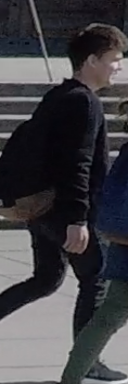

In [22]:
query

In [38]:
import cv2
from tqdm import tqdm
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO("/kaggle/input/weight-last-m/best_last_m.pt")
VIDEO_CODEC = "mp4v"
width,height = 1920,1080
# Open the video file
camid = 7
video_path = f"/kaggle/input/large-scale-multicamera-detection-dataset/Wildtrack/cam{camid}.mp4"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
print(f'FPS : {fps:0.2f}')
print("[INFO] starting video stream...")
out_video_name = f"out_test_{camid}.mp4"
out = cv2.VideoWriter(out_video_name,
                      fourcc=cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                      fps=fps,
                      frameSize=(width,height))


FPS : 59.94
[INFO] starting video stream...


In [39]:
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
start_from_frame = 0
cap.set(cv2.CAP_PROP_POS_FRAMES, start_from_frame)
n_frames_remain = n_frames - start_from_frame + 1

tqdm_bar = tqdm(range(500), total=n_frames_remain)

for frame in tqdm_bar:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
    success, frame = cap.read()

    if success:
        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = model.track(frame, conf=0.3, persist=True, verbose=False)[0]
        boxes_xyxy = results.boxes.xyxy.cpu().numpy().astype('int')
        galleries = extract_boxes(frame, boxes_xyxy)
        with torch.no_grad():
            gf = embedding_reid(galleries, embedding_model, device)
            dist = 1 - torch.mm(qf, gf.t()).cpu().detach().numpy()

        idx = np.argmin(dist[0])
        # Visualize the results on the frame
#         annotated_frame = results.plot()
        annotated_frame = cv2.rectangle(frame,
                                        (boxes_xyxy[idx, 0], boxes_xyxy[idx, 1]),
                                        (boxes_xyxy[idx, 2], boxes_xyxy[idx, 3]),
                                        color=(0,0,255), thickness=10)
        annotated_frame = cv2.putText(annotated_frame,
                                      str(round(dist[0, idx], 2)),
                                      (boxes_xyxy[idx, 0], boxes_xyxy[idx, 1] - 10),
                                      cv2.FONT_HERSHEY_SIMPLEX,
                                      1., (0,0,255), 4)
        tqdm_bar.set_postfix({'Distance': dist[0, idx]})
        # Display the annotated frame
        out.write(annotated_frame)

    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
out.release() 
cap.release()

  0%|          | 500/125875 [01:39<6:54:58,  5.04it/s, Distance=0.385]   


In [40]:
import IPython.display as ipd
ipd.Video(out_video_name, width=700)

In [41]:
from IPython.display import FileLink, display
display(FileLink(out_video_name))

/kaggle/working/out_test_7.mp4